# ABIO558 Project: The Impact of DN mutations on p63/73 function 

### Project Goals:
1. Outline the Plan for Data Analysis
2. Import the Data and Reorganize the Data (plate to long format, courtesy of Google)
3. Run a One-Way Anova, comparing between samples,
4. Run Post-Hoc Test, Tukey HSD, to see variance between samples
5. Print Data

# Research Question: 

# Necessary Background 
p63/p73 are transcription factors that regulate numerous distinct processes including the development of the epidermis and regulation of hippocampal development, respectively. Yet there are many different isoforms that exist in nature. These isoforms can be divided into their N-terminal variants, DeltaN or TA domains, and numerous C-terminal variants. The TA isoforms contain a TA domain in the N-termini which is as a transactivation domain that is required for initiation of gene transcription. The DeltaN isoforms lack this transactivation domain in the N-termini, but rather have a DeltaN domain which is a potential transctivation domain. 

# AIM
The aim of my project is to elucidate whether or not the DeltaN domains of both p63 and p73 are essential for gene expression and later work aims to understand the specific amino acid residues that are essential within the this potential TAD. 

# Methodology
To answer this question, a luciferase assay was used to measure gene expression. We transfected HCT116-p53KO cells with either the full length DNp63B or DNp73B, or with truncated mutants lacking the DN domain entirely. 



# Analysis Method

1. Load the Necessary Software and Tools
2. Establish File Directory and Load Files
3. Reshape the Data from Three Excel Sheets, one with Firefly Values, Nano Values, and the Plate Map
4. Calculate Normalized Ratio (firefly/nano)
5. Run One Way ANOVA to determine if there is a significant difference
6. Post Hoc Testing if necessary 

In [58]:
import pandas as pd
import numpy as np
import os 
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd # Import Tukey's tool

# File Paths
data_dir = '/Users/parmeshthakoordial/Desktop/ABIO558Assignment5'

firefly_path = os.path.join(data_dir, 'PT-11nov2025-fireflyLuc-p73muts.xlsx')
nano_path = os.path.join(data_dir, 'PT-11nov2025-nanoLuc-p73muts.xlsx')
plate_map_path = os.path.join(data_dir, 'LuciferaseAssayPlateTemplate11182025.xlsx')

ROW_HEADER_NAME = 'Row' 
ALPHA = 0.05 # Define alpha throughout the entire code

# Reshaping the Data from Plate to Long Format 
def plate_to_long_format(df, value_name):
    """
    Reshapes wide plate data (e.g., A1, A2...) into long format (Well, Value).
    """
    df = df.rename(columns={df.columns[0]: ROW_HEADER_NAME})
    df.columns = [str(col) if col != ROW_HEADER_NAME else col for col in df.columns]
    
    long_df = pd.melt(
        df, 
        id_vars=[ROW_HEADER_NAME], 
        var_name='Well_Column',      
        value_name=value_name        )
    
    long_df['Well'] = long_df[ROW_HEADER_NAME].astype(str) + long_df['Well_Column'].astype(str)
    
    # Return the full list of samples
    return long_df[['Well', value_name]].dropna(subset=[value_name])

def run_anova_and_data_prep():
    # 1. Import
    firefly_df_raw = pd.read_excel(firefly_path, header=0)
    nano_df_raw = pd.read_excel(nano_path, header=0)
    plate_map_df_raw = pd.read_excel(plate_map_path, header=0)

    plate_map_long = plate_to_long_format(plate_map_df_raw, 'Sample_ID')
    firefly_long = plate_to_long_format(firefly_df_raw, 'Luciferase_Value')
    nano_long = plate_to_long_format(nano_df_raw, 'Nano_Value')

    # 2. Merge Data
    merged_df = pd.merge(plate_map_long, firefly_long, on='Well', how='inner') 
    final_df = pd.merge(merged_df, nano_long, on='Well', how='inner')
    
    # --- ADDED CODE BLOCK TO CONVERT TO NUMERIC ---
    # Realized this is necessary from gemmini, code did not work prior as there were non-numeric values on the sheet. This converts non-numeric values to NaN
    final_df['Luciferase_Value'] = pd.to_numeric(final_df['Luciferase_Value'], errors='coerce')
    final_df['Nano_Value'] = pd.to_numeric(final_df['Nano_Value'], errors='coerce')
   
    # After conversion, drop rows where the values are now NaN 
    final_df.dropna(subset=['Luciferase_Value', 'Nano_Value'], inplace=True)
    
    # 3. Calculate Normalized Ratio (Firefly/Nano)
    # Prevent division by zero
    final_df['Nano_Value_Safe'] = np.where(final_df['Nano_Value'] == 0, 1e-9, final_df['Nano_Value'])
    final_df['Normalized_Ratio'] = final_df['Luciferase_Value'] / final_df['Nano_Value_Safe']

    # Final DataFrame selection
    per_well_results = final_df[['Sample_ID', 'Luciferase_Value', 'Nano_Value', 'Normalized_Ratio']]
    
    # Print the data table
    print("\n## Normalized Replicate Data (Firefly/Nano)")
    print(per_well_results.round(4).to_string())

    # ONE-WAY ANOVA, Extract data groups
    groups = [group['Normalized_Ratio'].values for name, group in per_well_results.groupby('Sample_ID')]
    
    # Perform the one-way ANOVA
    f_statistic, p_value = stats.f_oneway(*groups)
    print(f"\n## ONE-WAY ANOVA RESULTS")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")

    # Interpret
    alpha = ALPHA # 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: The means are significantly different. Running Post-hoc Tukey's HSD.")
    else:
        print("Fail to reject the null hypothesis: The means are not significantly different. No post-hoc test needed.")
        
    return per_well_results, p_value, alpha

def run_tukey_hsd(per_well_results, p_value, alpha):
    if p_value < alpha:
        print("\n## TUKEY'S HSD POST-HOC TEST RESULTS")
        
        # Correct input format: one column of values, one column of groups
        tukey_results = pairwise_tukeyhsd(
            endog=per_well_results['Normalized_Ratio'],
            groups=per_well_results['Sample_ID'],
            alpha=alpha
        )
        print(tukey_results.summary())
        print("\nNote: 'reject=True' indicates a statistically significant difference (p < 0.05) between the two groups.")

if __name__ == '__main__':
    
    # 1. Run Data Prep and ANOVA (Box 2)
    data_for_tukey, anova_p_value, significance_alpha = run_anova_and_data_prep()
    
    # 2. Run Tukey's HSD (Box 3)
    run_tukey_hsd(data_for_tukey, anova_p_value, significance_alpha)


## Normalized Replicate Data (Firefly/Nano)
      Sample_ID  Luciferase_Value  Nano_Value  Normalized_Ratio
0    HCT116 WT              152.0   4411142.0            0.0000
1    HCT116 WT              134.0   4359801.0            0.0000
2    HCT116 WT              141.0   4440581.0            0.0000
3    HCT116 MUT             261.0   2731872.0            0.0001
4    HCT116 MUT             397.0   4152924.0            0.0001
5    HCT116 MUT             200.0   1562676.0            0.0001
6    DNp63B WT             2532.0    899757.0            0.0028
7    DNp63B WT             3853.0    759727.0            0.0051
8    DNp63B WT             2200.0    585231.0            0.0038
9    DNp63B MUT              10.0     37589.0            0.0003
10   DNp63B MUT              20.0    117762.0            0.0002
11   DNp63B MUT              17.0    105346.0            0.0002
12  DDNp63B WT               57.0    155792.0            0.0004
13  DDNp63B WT               58.0    214641.0            0.


## Normalized Replicate Data (Firefly/Nano)
      Sample_ID  Luciferase_Value  Nano_Value  Normalized_Ratio
0    HCT116 WT              152.0   4411142.0            0.0000
1    HCT116 WT              134.0   4359801.0            0.0000
2    HCT116 WT              141.0   4440581.0            0.0000
3    HCT116 MUT             261.0   2731872.0            0.0001
4    HCT116 MUT             397.0   4152924.0            0.0001
5    HCT116 MUT             200.0   1562676.0            0.0001
6    DNp63B WT             2532.0    899757.0            0.0028
7    DNp63B WT             3853.0    759727.0            0.0051
8    DNp63B WT             2200.0    585231.0            0.0038
9    DNp63B MUT              10.0     37589.0            0.0003
10   DNp63B MUT              20.0    117762.0            0.0002
11   DNp63B MUT              17.0    105346.0            0.0002
12  DDNp63B WT               57.0    155792.0            0.0004
13  DDNp63B WT               58.0    214641.0            0.

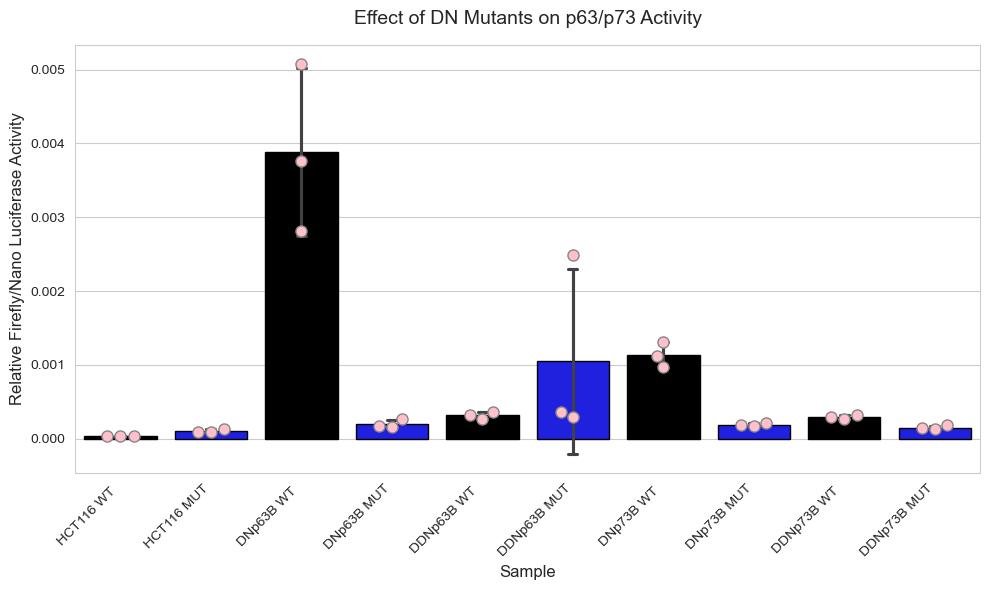

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

def create_bar_plot(df):
    
    #color scheme 
    sample_ids = df['Sample_ID'].unique()
    custom_palette = {}
    
    for sample in sample_ids:
        # Assign colors based on name Wt or mut 
        if 'mut' in sample.lower():
            custom_palette[sample] = 'blue'  # Mutant samples are blue
        elif 'wt' in sample.lower() or 'wild-type' in sample.lower():
            custom_palette[sample] = 'black' # Wild-type samples are black
        else:
            custom_palette[sample] = 'lightgray' # Default color for others (e.g., control)

    # style
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(10, 6))
    
    # 2. Create Bar Plot with Custom Colors 
    bar_plot = sns.barplot(
        x='Sample_ID', 
        y='Normalized_Ratio', 
        data=df, 
        capsize=0.1,            
        errorbar=('sd', 1),      
        
        # --- COLOR FIX ---
        hue='Sample_ID',         
        palette=custom_palette,  
        legend=False,            
        edgecolor='black'        
    )

    # 3. Overlay the Individual points onto the bar (Swarm Plot)
    sns.swarmplot(
        x='Sample_ID', 
        y='Normalized_Ratio', 
        data=df, 
        color='pink',           
        size=8,                  
        linewidth=1            
    )
  
    # 4. Add Labels and Title
    plt.xlabel('Sample', fontsize=12)
    plt.ylabel('Relative Firefly/Nano Luciferase Activity', fontsize=12)
    plt.title('Effect of DN Mutants on p63/p73 Activity', fontsize=14, pad=15)
    
    # rotates x-labels to see better 
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    
    try:
        # 1. Run Data Prep and ANOVA (Generates the data)
        data_for_plot, anova_p_value, significance_alpha = run_anova_and_data_prep()
        
        # 2. Run Tukey's HSD
        run_tukey_hsd(data_for_plot, anova_p_value, significance_alpha)
        
        # 3. Generate Plot
        print("\nGenerating Color-Coded Bar Plot...")
        create_bar_plot(data_for_plot)
        
    except Exception as e:
        # This catches any errors that occurred during data loading, ANOVA, or plotting
        print(f"\nAn error occurred during the script execution: {e}")

# p63 MUT Graph 


## Normalized Replicate Data (Firefly/Nano)
      Sample_ID  Luciferase_Value  Nano_Value  Normalized_Ratio
0     HCT116 WT             152.0   4411142.0            0.0000
1     HCT116 WT             134.0   4359801.0            0.0000
2     HCT116 WT             141.0   4440581.0            0.0000
3    HCT116 MUT             261.0   2731872.0            0.0001
4    HCT116 MUT             397.0   4152924.0            0.0001
5    HCT116 MUT             200.0   1562676.0            0.0001
6     DNp63B WT            2532.0    899757.0            0.0028
7     DNp63B WT            3853.0    759727.0            0.0051
8     DNp63B WT            2200.0    585231.0            0.0038
9    DNp63B MUT              10.0     37589.0            0.0003
10   DNp63B MUT              20.0    117762.0            0.0002
11   DNp63B MUT              17.0    105346.0            0.0002
12   DDNp63B WT              57.0    155792.0            0.0004
13   DDNp63B WT              58.0    214641.0            0.

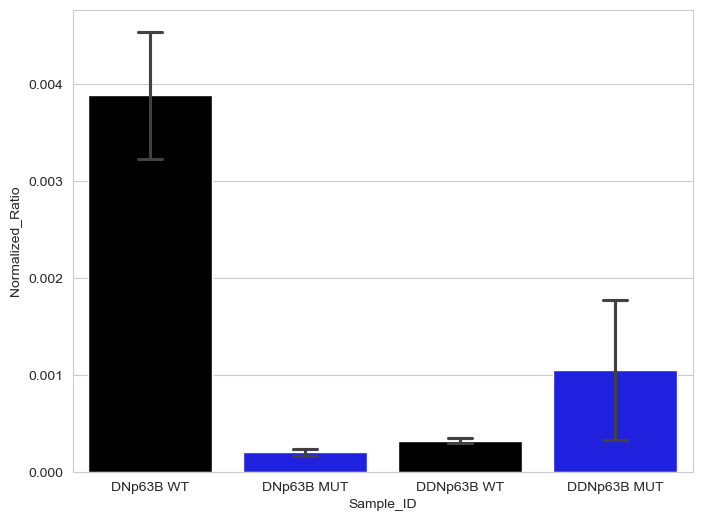

In [63]:
def create_bar_plot_p63_only(results_df):

    # 1. Filter the data include only samples 'p63'
    p63_df = results_df[results_df['Sample_ID'].str.contains('p63', case=False, na=False)].copy()

    # 2. Color based on Sample_ID
    sample_ids = p63_df['Sample_ID'].unique()
    custom_palette = {}
    
    for sample in sample_ids:
        # colors based on name: mut -> blue, wt -> black
        if 'mut' in sample.lower():
            custom_palette[sample] = 'blue'
        elif 'wt' in sample.lower() or 'wild-type' in sample.lower():
            custom_palette[sample] = 'black'


    # 3. Create the bar plot 
    plt.figure(figsize=(8, 6))
    
    sns.barplot(
        x='Sample_ID', 
        y='Normalized_Ratio', 
        data=p63_df,
        errorbar='se',        
        capsize=0.15,         
        

        hue='Sample_ID',        
        palette=custom_palette, 
 
        order=sample_ids      
    )

    # 4. Significance bars did not work and we do not see them 
    if tukey_results_obj is not None:
        
        # Define the specific requested comparisons (MUST match the names in p63_df)
        box_pairs = [
            ("DNp63B WT", "DNp63B MUT"), 
            ("DDNp63B WT", "DDNp63B MUT"),
            ("DNp63B WT", "DDNp63B WT")
        ]
        
        # Convert the Tukey results table to a DataFrame
        tukey_df = pd.DataFrame(data=tukey_results_obj._results_table.data[1:], columns=tukey_results_obj._results_table.data[0])
        pvalue_col = 'p-adj' # Use 'p-adj' to avoid the 'pval' error

        # Create the annotation DataFrame required by Annotator
        annot_df = pd.DataFrame({
            'group1': tukey_df['group1'],
            'group2': tukey_df['group2'],
            'p-value': tukey_df[pvalue_col], 
            'reject': tukey_df['reject']
        })

        # Initialize the Annotator
        annotator = Annotator(
            ax, box_pairs, data=p63_df, x='Sample_ID', y='Normalized_Ratio', order=sample_ids
        )
        
        # Add the annotations based on the Tukey results
        annotator.set_custom_annotations(
            annot_df, 
            pvalue_thresholds=[
                {'pvalue': 0.001, 'label': "***"},
                {'pvalue': 0.01, 'label': "**"},
                {'pvalue': 0.05, 'label': "*"},
                {'pvalue': 1.0, 'label': "ns"}
            ]
        )
        
        # Configure and draw the significance bars
        annotator.configure(text_format='star', loc='inside', line_height=0.03, line_offset_to_group=0.1)
        annotator.apply_and_annotate()
        
    # 5 Customizations
    plt.title('Normalized Luciferase Activity (Firefly/Nano) p63 Samples', fontsize=14)
    plt.xlabel('p63 Variants', fontsize=12)
    plt.ylabel('Normalized Ratio', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 6 Display the plot
    plt.show()

if __name__ == '__main__':
    
    try:
        # 1. Run Data Prep and ANOVA 
        data_for_plot, anova_p_value, significance_alpha = run_anova_and_data_prep()
        
        # 2. Run Tukey's HSD
        run_tukey_hsd(data_for_plot, anova_p_value, significance_alpha)
        
        # 3. Generate the new p63-only plot
        create_bar_plot_p63_only(data_for_plot)
        
    except FileNotFoundError as e:
        print(f"\nERROR: File not found. Please ensure all Excel files exist and your 'data_dir' path is correct.")
        print(f"Missing file: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred during the script execution: {e}")

# P73 Mutants Graph Only


## Normalized Replicate Data (Firefly/Nano)
      Sample_ID  Luciferase_Value  Nano_Value  Normalized_Ratio
0    HCT116 WT              152.0   4411142.0            0.0000
1    HCT116 WT              134.0   4359801.0            0.0000
2    HCT116 WT              141.0   4440581.0            0.0000
3    HCT116 MUT             261.0   2731872.0            0.0001
4    HCT116 MUT             397.0   4152924.0            0.0001
5    HCT116 MUT             200.0   1562676.0            0.0001
6    DNp63B WT             2532.0    899757.0            0.0028
7    DNp63B WT             3853.0    759727.0            0.0051
8    DNp63B WT             2200.0    585231.0            0.0038
9    DNp63B MUT              10.0     37589.0            0.0003
10   DNp63B MUT              20.0    117762.0            0.0002
11   DNp63B MUT              17.0    105346.0            0.0002
12  DDNp63B WT               57.0    155792.0            0.0004
13  DDNp63B WT               58.0    214641.0            0.

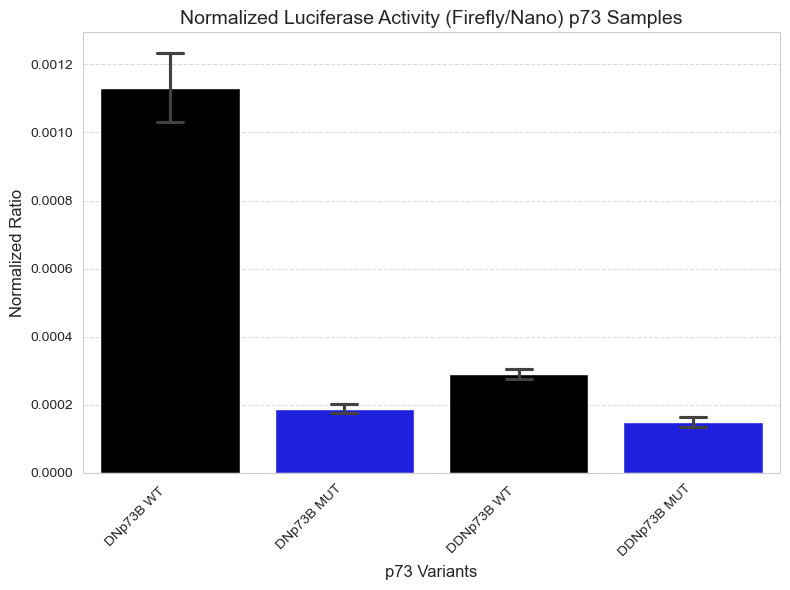

In [37]:
def create_bar_plot_p73_only(results_df):

    # 1. Filter the data include only samples 'p73'
    p73_df = results_df[results_df['Sample_ID'].str.contains('p73', case=False, na=False)].copy()

    # 2. Color based on Sample_ID
    sample_ids = p73_df['Sample_ID'].unique()
    custom_palette = {}
    
    for sample in sample_ids:
        # colors based on name: mut -> blue, wt -> black
        if 'mut' in sample.lower():
            custom_palette[sample] = 'blue'
        elif 'wt' in sample.lower() or 'wild-type' in sample.lower():
            custom_palette[sample] = 'black'


    # 3. Create the bar plot 
    plt.figure(figsize=(8, 6))
    
    sns.barplot(
        x='Sample_ID', 
        y='Normalized_Ratio', 
        data=p73_df,
        errorbar='se',        
        capsize=0.15,         
        

        hue='Sample_ID',        # Assign x-variable to hue
        palette=custom_palette, # Pass the custom colors
 
        order=sample_ids      
    )
    
    # 4. Customizations
    plt.title('Normalized Luciferase Activity (Firefly/Nano) p73 Samples', fontsize=14)
    plt.xlabel('p73 Variants', fontsize=12)
    plt.ylabel('Normalized Ratio', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 5. Display the plot
    plt.show()

if __name__ == '__main__':
    
    try:
        # 1. Run Data Prep and ANOVA 
        data_for_plot, anova_p_value, significance_alpha = run_anova_and_data_prep()
        
        # 2. Run Tukey's HSD
        run_tukey_hsd(data_for_plot, anova_p_value, significance_alpha)
        
        # 3. Generate the new p73-only plot
        create_bar_plot_p73_only(data_for_plot)
        
    except FileNotFoundError as e:
        print(f"\nERROR: File not found. Please ensure all Excel files exist and your 'data_dir' path is correct.")
        print(f"Missing file: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred during the script execution: {e}")

# Bartletts Test for p63 Samples 

In [56]:
import scipy.stats as stats
import numpy as np

# load data samples. 
DNp63BWT = [0.0028, 0.0038, 0.0051]
DNp63BMUT = [0.0002, 0.0003, 0.0002]

# Perform Bartlett's test
statistic, p_value = stats.bartlett(DNp63BWT, DNp63BMUT)

# Print results
print(f"Bartlett's test statistic: {statistic}")
print(f"P-value: {p_value}")

# interpret with a of 0.05 
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: At least one group has a different variance.")
else:
    print("Fail to reject the null hypothesis: The variances among groups are not significantly different (assume equal variances).")


Bartlett's test statistic: 7.37227730592993
P-value: 0.00662369990733554
Reject the null hypothesis: At least one group has a different variance.
